In [1]:
from typing import NamedTuple, Any, Optional
import math
import numpy as np
from scipy import sparse
import osqp
import json
import sys
import argparse
import pandas as pd 
import matplotlib.pyplot as plt
import functools 

# Energy Forward Market Simulation 
### Details
- 2021 only. 
- ERCOT only for net load, day ahead market prices, and load. 
- We only clear monthly products, for each load zone.

### Modeling (v1)
- Only ERCOT zone, so we use hub average prices
- 3 agents, Load Serving Entities (LSEs) are buyers, and generators are sellers. Financial arbitrageurs are also included.
- Get a forecast of net load (defined as load less wind and solar production) and day ahead prices for all load zones, for all periods. Using historical data, we add some white noise so that forecasts are not exact. 
- Use the day ahead price, and net load forecast as a signal for all participants. Assume that they have similar expectations in price. 
- In v1, we only use 3 agents, each of different type

### Utility Functions

In [2]:
import os
PTH = '/Users/richardz/Desktop/Projects/energy_forward_market/data'
#PTH = 'C://Users//richa//Documents//energy_forward_market//data'
LOAD_FILE = 'load_2021.xlsx'
DAM_PRICES_FILE = 'dam_spp_2021.xlsx'
RENEW_FILE = 'wind_solar_2021.xlsx'

# get the historical load data for a specific zone
def get_load(zone): 
	pass

# get the average price of all hubs in ERCOT
def get_dam_prices(zone='HB_BUSAVG'): 
	months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
	df = pd.DataFrame()
	for month in months: 
		dam_prices = pd.read_excel(os.path.join(PTH, DAM_PRICES_FILE), sheet_name=month)
		dam_prices = dam_prices[dam_prices['Settlement Point'] == zone]
		df = pd.concat([df, dam_prices], axis=0)
		
	return df

# get the wind and solar data
def get_wind_solar(): 
	wind_sheet = 'Wind Data'
	solar_sheet = 'Solar Data'
	wind_data = pd.read_excel(os.path.join(PTH, RENEW_FILE), sheet_name=wind_sheet)
	solar_data = pd.read_excel(os.path.join(PTH, RENEW_FILE), sheet_name=solar_sheet)
	return wind_data, solar_data


In [4]:
dam_prices = get_dam_prices()

def adjust_hour_and_date(row):
    if row['Hour Ending'] == '24:00':
        row['Hour Ending'] = '00:00'
        row['Delivery Date'] = pd.to_datetime(row['Delivery Date']) + pd.Timedelta(days=1)
    return row

dam_prices = dam_prices.apply(adjust_hour_and_date, axis=1)
dam_prices['Hour Ending'] = pd.to_datetime(dam_prices['Hour Ending'], format='%H:%M')
dam_prices['Delivery Date'] = pd.to_datetime(dam_prices['Delivery Date'])
dam_prices['Date'] = dam_prices.apply(lambda row: pd.datetime.combine(row['Delivery Date'], row['Hour Ending'].time()), axis=1)
dam_prices.set_index('Date', inplace=True)

wind, solar = get_wind_solar()
wind.set_index('Date', inplace=True)
solar.set_index('Date', inplace=True)
net_load = wind[['ERCOT.LOAD', 'ERCOT.WIND.GEN']].join(solar[['ERCOT.PVGR.GEN']], on='Date', lsuffix='.wind', rsuffix='.solar')
net_load['net_load'] = net_load['ERCOT.LOAD'] - net_load['ERCOT.WIND.GEN'] - net_load['ERCOT.PVGR.GEN']
sim = dam_prices.join(net_load, on='Date', how='inner')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/richardz/Desktop/Projects/energy_forward_market/data/dam_spp_2021.xlsx'

### Modeling agent preferences
We assume a "template" offer curve for each participant type, of which there are 3 distinct types, which are either net buyer, net seller, or arbitrageur. Each offer (demand) curve is parameterized by only scalar risk attitudes, and capital costs. Risk attitude and capital costs are related, and determine the slope and level of the offer curve. Additionally, each participant type differs in their general offering strategy. 

- Financial participants are agnostic between buying or selling, but require higher payment for taking larger positions (steeper slope). They aim to have a position of 0 target around their expected price. 
- Generators are natural sellers willing to sell slightly below their expected price, and can even buy if they have physical assets that allow them to do so (batteries, hydro)
- LSE are natural buyers, who offer at a premium to the other participants compared to their expected price, due to the extreme volatility of electricity prices.

Each offer curve has the property that it is convex in demand when selling, and concave in demand when buying. This is captures economic intuition behind how agents operate their business.  

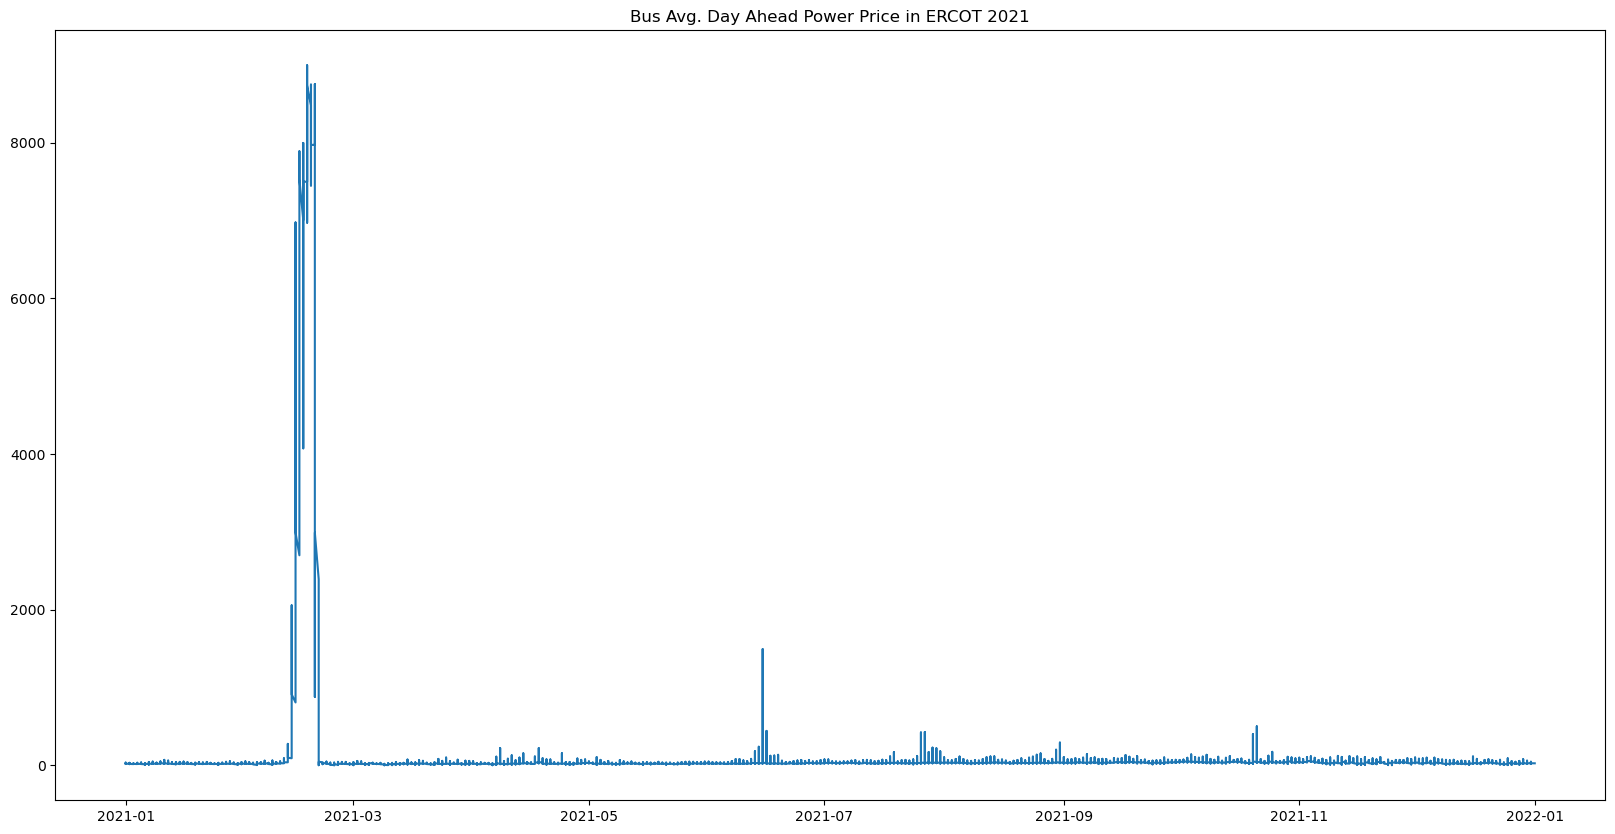

In [4]:
plt.figure(figsize=(20,10))
plt.plot(dam_prices['Delivery Date'], dam_prices['Settlement Point Price'])
plt.title('Bus Avg. Day Ahead Power Price in ERCOT 2021')
plt.show()

## Flow Orders 
A flow order is characterized by 5 parameters, $\mathbf{w}, p_H, p_L, q_i, q_{c}$.

- $\mathbf{w}$ is a list of weights of all products that are traded. This vector should sum to 1. 
- $p_H$ is the high price of the portfolio. 
- $p_L$ is the low price of the portfolio. 
- $q_i$ is the maximum quantity that the portfolio should be traded. 
- $q_{c}$ is the cumulative maximum quantity that should be traded. This doesn't really get used because I only clear the market once. 

In [5]:
# Jason Dark's bid class
class Bid(NamedTuple):
    q: tuple[float, float]
    p: tuple[float, float]
    w: list[tuple[str, float]]

    # This is for internal book-keeping / un-canonicalizing bids. Above when
    # we said this implementation does nothing fancy, that was a partial lie.
    # It has been observed by
    # Pete Kyle <https://www.rhsmith.umd.edu/directory/albert-pete-kyle>
    # that the number of unique portfolios is likely small, at least when
    # scaled into an appropriate norm. This provides opportunities for matrix
    # factorizations. This implementation does not exploit these opportunities,
    # but, as a pedagogical exercise, rescaling bids is likely to be part of
    # any real implementation, so we do the necessary book-keeping here to
    # illustrate how it might be done.
    scale: float
    # the name of the bidder that submitted the bid
    bidder: str

    # Below are two methods that are used to construct the negative-slope and
    # y-intercept of the bids.
    def slope(self) -> float:
        # We explicitly choose to handle the slope as a positive value
        return (self.p[0] - self.p[1]) / (self.q[1] - self.q[0])

    def pzero(self) -> float:
        # y - y0 = m * (x - x0) => y = y0 - m * x0 = y0 + (-m) * x0
        return self.p[0] + self.slope() * self.q[0]
    
    # Call this method with the optimization output to report the result
    # with respect to the original, uncanonicalized bid. See the (un)scaling
    # at work.
    def report(self, rate: float, prices: dict[str, float]):
        return rate / self.scale, self.scale * math.fsum(value * prices[key] for key, value in self.w)

    # Given a set of prices, what would this bid do? Returns the (primal, dual) pair
    def respond(self, prices: dict[str, float]):
        price = math.fsum(value * prices[key] for key, value in self.w)
        if price > self.p[0]:
            return self.q[0], self.p[0] - price
        elif price < self.p[1]:
            return self.q[1], self.p[1] - price
        elif self.p[0] == price == self.p[1]:
            # Hard to do a good warm-start here, so we pick the norm minimizer
            return 0, 0
        else:
            return self.q[0] - (price - self.p[0]) / self.slope(), 0

    # If you are curious, this is the method that canonicalizes the bid.
    @staticmethod
    def from_dict(data: dict[str, Any]) -> 'Bid':
        bidder = data.get("bidder")
        q0 = -float(data.get("sell", 0))
        q1 = +float(data.get("buy", 0))
        assert q0 <= 0, "sell quantitity must be non-negative"
        assert q1 >= 0, "buy quantity must be non-negative"

        # Prices can either be price = X, or price = [X, Y].
        # The former implicitly expands to [X, X]
        p_raw = data.get("price")
        assert isinstance(p_raw, list) and len(p_raw) == 2, "price must be specified as [low, high]"
        p1, p0 = map(float, p_raw)
        assert p0 >= p1, "price array must be sorted"

        # Now for the portfolios
        weights = [
            (key, float(value))
            for key, value in data.get("weights", {}).items()
            if value != 0
        ]

        # First, we define a canonical ordering. Here, it is just alphabetical.
        weights.sort()

        # Second, we scale the vector to unit L2 norm
        # TODO: write this in a way that avoids potential overflow of the sum.
        scale = math.fsum(value * value for (_, value) in weights)
        scale = math.sqrt(scale)

        # Third, we normalize the signs
        flip = weights[0][1] < 0
        if flip:
            scale *= -1
        weights = [(key, value / scale) for key, value in weights]
        q0 *= scale
        q1 *= scale
        p0 /= scale
        p1 /= scale
        if flip:
            q0, q1 = q1, q0
            p0, p1 = p1, p0
        
        # Now, all portfolios are defined in terms of unit directions with the
        # first non-zero forced to be positive. This allows us to implement
        # Pete-inspired simplifications, though we do not presently do so.
        return Bid((q0, q1), (p0, p1), weights, scale, bidder)

## Market Clearing

Suppose we have a flow order $i$. Recall that we linearly interpolate $p_L, p_H$ in the flow order, and thus we have implicitly assumed that price is linear in demand. This means that our marginal utility function is also linear: 

$$M_i(x_i) = p^{H}_i - \frac{p^{H}_i - p^{L}_i}{q_i}x_i, x_i \in [0, q_i]$$
To get the utility function of an order, we integrate the marginal utility function to get a quadratic function in demand. The market clearing is thus a quadratic optimization problem. The primal optimization problem is to maximize gains from bidded orders, and the dual is minimizing cost of non clearing prices. 

This market clearing algorithm solves the quadratic optimization problem: 

$$\max_{\mathbf{x}} \mathbf{x}^T\mathbf{p}^{H} - \frac{1}{2}\mathbf{x}^T\mathbf{D}\mathbf{x}$$

- $\mathbf{x}$ is the vector of clearing "trade rates" or quantities/time for each order
- $\mathbf{p}^{H}$ is the vector the of the high price on each orde. 
- $\mathbf{D}$ is a matrix of the quantity $\frac{p^{H}_i - p^{L}_i}{q_i}$. We call this the liquidity matrix. 

In [6]:
# This function has the actual QP solver logic. This is Jason Dark's solver. 
def solve(
        bids: list[Bid],
        pguess: Optional[dict[str, float]],
        settings: dict[str, Any]
    ) -> tuple[list[float], dict[str, float]]:

    # Establish the canonical ordering of the decision variables
    products = sorted(set(key for bid in bids for (key, _) in bid.w))
    indices = { product: index for (index, product) in enumerate(products) }

    # TODO: with some book-keeping, possible to partially warm-start. For now,
    # throw an error if trying to warm-start with incomplete pricing info.
    assert pguess is None or all(product in pguess for product in products), "warm-starting must specify all prices"

    # OSQP solves min <x, Px>/2 + <q,x> s.t. l <= Ax <= u. So we need to
    # massage our problem data into this format.
    model = osqp.OSQP()

    # This comes directly from the bids
    P = sparse.diags([list(bid.slope() for bid in bids)], [0], format="csc")
    q = np.array(list(-bid.pzero() for bid in bids))

    # These are the market clearing constraints, 1 per product
    leq = np.zeros(len(products))
    ueq = np.zeros(len(products))
    Aeq = sparse.dok_matrix((len(products), len(bids)))
    for j, bid in enumerate(bids):
        for (key, value) in bid.w:
            i = indices[key]
            Aeq[i, j] = value

    # These are the execution constraints, 1 per bid
    lin = np.array(list(bid.q[0] for bid in bids))
    uin = np.array(list(bid.q[1] for bid in bids))
    Ain = sparse.eye(len(bids))

    # Unify the constraints
    l = np.concatenate((leq, lin))
    u = np.concatenate((ueq, uin))
    A = sparse.vstack((Aeq, Ain), format="csc")

    # TODO: convergence, parameters, etc. This stuff is important for a real
    # solver!
    model.setup(P=P, q=q, A=A, l=l, u=u, **settings)

    # To facilitate changing orders but relatively constant prices,
    # we warm-start from prices alone. It is trivial to estimate
    # each bid's primal and dual values under profit-maximization,
    # which should be "close" to gains-from-trade maximizer.
    if pguess is not None:
        # The individual bid knows how to respond to the prices
        x0, y0 = zip(*iter(bid.respond(pguess) for bid in bids))
        # Just convert to Numpy for simplicity
        x0 = np.array(x0)
        # We inject the product prices first, followed by the bid dual values
        y0 = np.concatenate(([pguess[product] for product in products], y0))
        # Now we simply warm-start the solver at the primal/dual values
        model.warm_start(x=x0, y=y0)

    results = model.solve()
    return list(results.x), dict(zip(products, results.y))

## Simulation

For the simulation, we assume that the 3 participants submit 4-part flow offers that reflect their willingness to purchase a flow value. These offers are reflective of risk attitude and capital costs. The market operator provides a forward forecast (in this case we use the historical value) for prices along with a forecast of net load. The three participants submit bids around these prices which include these loads. We assume a price range of $[0, 2]$ as a multiple of the forecasted price. 


Note that the forecasted price is reflected of $\mathbf{marginal}$ cost of generation. The forward market has the participants bid their $\mathbf{opportunity}$ cost. 

In [68]:
class Participant(): 
    
    # risk_attitude: is a scalar in [0,1]. 1 is for a perfectly risk neutral participant. ~.9 for small generators
    # capital_costs: is a scalar in [.06, .12] that shifts the offer curve up or down. 
    def __init__(self, risk_attitude, capital_costs, name): 
        self.risk_attitude = risk_attitude
        self.capital_costs = capital_costs 
        self.name = name

    # get_offer_points :return a set of four tuples that indicate (price, quantity) pairs that we use to construct the flow orders
    # this is based on the expected price that the participant anticipates from a forecast. 
    # the prices must be monotonically increasing
    # expected_price: the anticipated price of power in $/MWh
    # net_demand: the sum (demand - supply) for each participant. 
    def get_offer_points(self, expected_price, net_demand, forecasted_net_load):
        pass

    # assume that offer points are a set of 4 tuples that specify (p_i, q_i) for price and quantity
    def get_flow_orders(self, offer_points): 

        flow_orders = [] 
        
        # high sell order 
        p_H = offer_points[0][0]
        p_L = offer_points[1][0]
        q2 = offer_points[1][1]
        q1 = offer_points[0][1]
        
        order1 = None
        if p_L >= p_H:
            order1 = {'price': [p_H, p_L], 'sell': np.abs(q1 - q2), 'weights': {'X': 1}, 'bidder': self.name}
        else:
            order1 = {'price': [p_L, p_H], 'sell': np.abs(q1 - q2), 'weights': {'X': 1}, 'bidder': self.name}

        # low buy order 
        p_H = offer_points[2][0]
        p_L = offer_points[3][0]
        q2 = offer_points[3][1]
        q1 = offer_points[2][1]
        order2 = {'price': sorted([p_L, p_H]), 'buy': np.abs(q1 - q2), 'weights': {'X': 1}, 'bidder': self.name}
        
        # middle order. need to find slope of the line and y intercept 
        # y = ax + b 
        p_H = offer_points[1][0]
        p_L = offer_points[2][0]
        q2 = offer_points[1][1]
        q1 = offer_points[2][1]
        mid_slope = (p_H - p_L) / (q2 - q1)
        mid_int = p_H - mid_slope * q2
        
        order3 = {'price': sorted([mid_int, p_H]), 'sell': np.abs(q2), 'weights': {'X': 1}, 'bidder': self.name}
        order4 = {'price': sorted([p_L, mid_int]), 'buy': np.abs(q1), 'weights': {'X': 1}, 'bidder': self.name}
        flow_orders.append(Bid.from_dict(order1))
        flow_orders.append(Bid.from_dict(order2))
        flow_orders.append(Bid.from_dict(order3))
        flow_orders.append(Bid.from_dict(order4))

        return flow_orders
    
    def get_name(self): 
        return self.name

class Seller(Participant): 
    
    def get_offer_points(self, expected_price, net_demand): 
        discounted_expected_price = expected_price / (1 - self.capital_costs)

        # we assume that an arbitrageur has a relatively high risk attitude close to 1.
        # From their expected price, they are willing to buy large quantities far below expected prices, 
        # and sell large quantities far above expected prices
        # for now, just assume that within 1.5 - 2 multiples of the expected price, the arbitrageur sells with slope 1 in price. 
        
        p1 = 1.06 * discounted_expected_price
        p2 = 0.95 * discounted_expected_price
        p3 = 0.5 * discounted_expected_price 
        p4 = 0.4 * discounted_expected_price
        q1 = -1 * net_demand * self.risk_attitude
        q2 = -.75 * net_demand * self.risk_attitude
        q3 = .25 * net_demand * self.risk_attitude
        q4 = .5 * net_demand * self.risk_attitude
        
        return [(p1, q1), (p2, q2), (p3, q3), (p4, q4)]
    
    def get_flow_orders(self, offer_points): 
        return super().get_flow_orders(offer_points)

class Buyer(Participant): 
    
    def get_offer_points(self, expected_price, net_demand): 
        discounted_expected_price = expected_price / (1 - self.capital_costs)
        risk_premium = 1 / (self.risk_attitude)
        p1 = 1.5 * self.risk_attitude * discounted_expected_price
        p2 = 1.3 * self.risk_attitude * discounted_expected_price
        p3 = 0.9 * self.risk_attitude * discounted_expected_price 
        p4 = 0.8 * self.risk_attitude * discounted_expected_price
        
        q1 = -.5 * self.risk_attitude * net_demand 
        q2 = -.25 * self.risk_attitude * net_demand 
        q3 = .9 * self.risk_attitude * net_demand
        q4 = 1 * self.risk_attitude * net_demand

        return [(p1, q1), (p2, q2), (p3, q3), (p4, q4)]
    
    def get_flow_orders(self, offer_points): 
        return super().get_flow_orders(offer_points)

# The arbitrageur offers two points at the forecasted_net_load and -forecasted_net_load
class Arbitrageur(Participant): 
    
    def get_offer_points(self, expected_price, net_demand, forecasted_net_load): 
        discounted_expected_price = expected_price / (1 - self.capital_costs)

        p1 = 1.6 * self.risk_attitude * discounted_expected_price + 0.01
        p2 = 1.1 * self.risk_attitude * discounted_expected_price
        p3 = 0.6 * self.risk_attitude * discounted_expected_price 
        p4 = 0.4 * self.risk_attitude * discounted_expected_price
        q1 = -1.3 * forecasted_net_load * self.risk_attitude
        q2 = -1 * forecasted_net_load * self.risk_attitude
        q3 = 1 * forecasted_net_load * self.risk_attitude
        q4 = 1.3 * forecasted_net_load * self.risk_attitude

        return [(p1, q1), (p2, q2), (p3, q3), (p4, q4)]
    
    # assume that offer points are a set of 4 tuples that specify (p_i, q_i) for price and quantity
    def get_flow_orders(self, offer_points): 
        return super().get_flow_orders(offer_points)

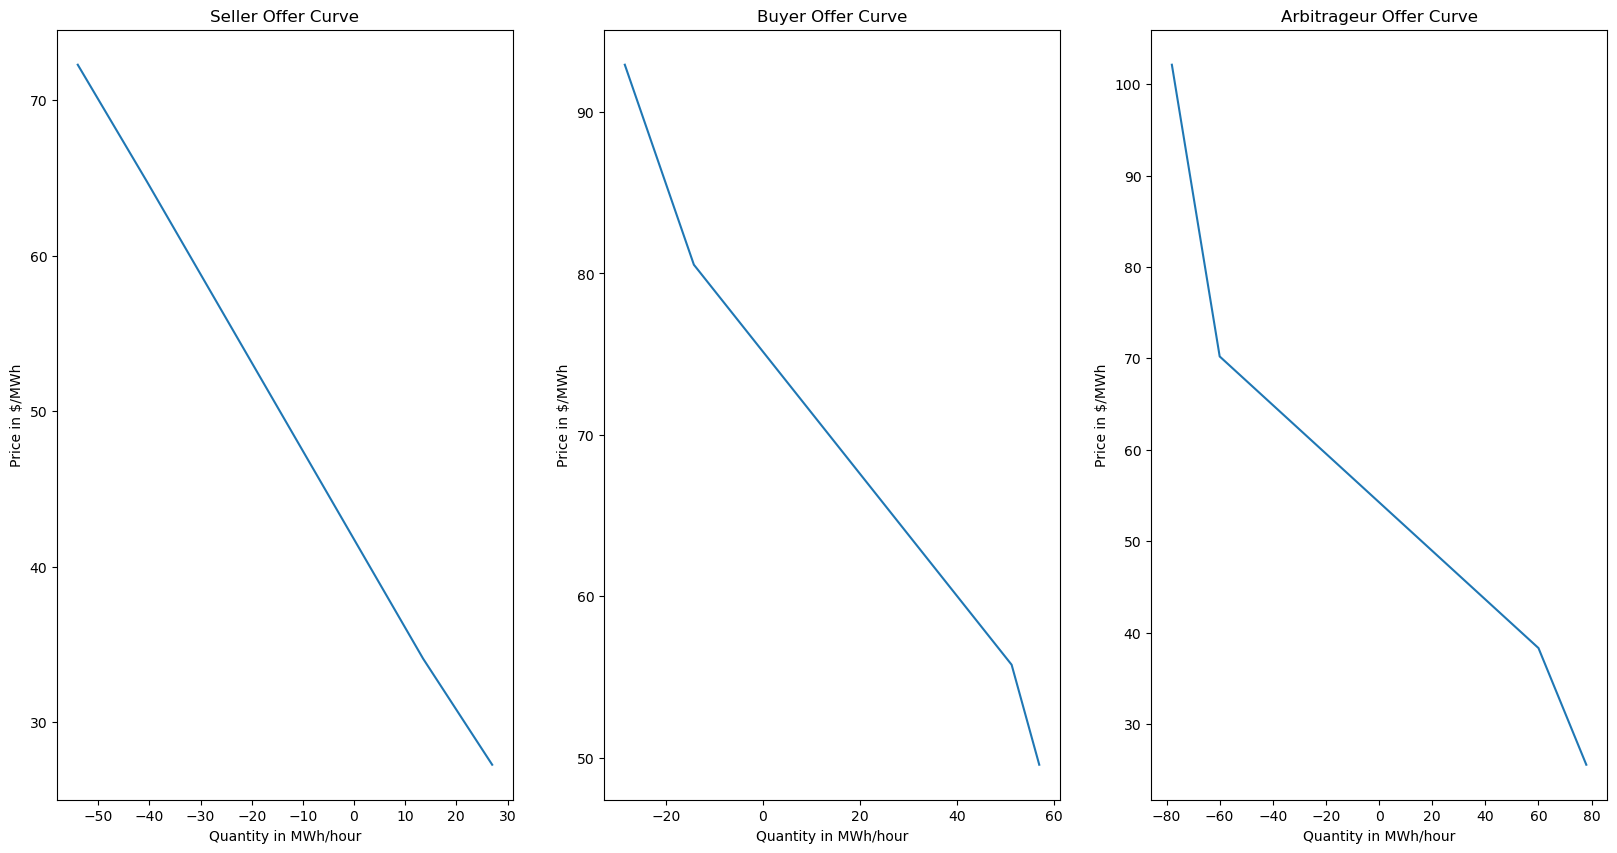

In [69]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))
seller = Seller(.95, .06, name='seller1')
buyer = Buyer(.95, .08, name='buyer1')
arb = Arbitrageur(.95, .08, name='arb1')

seller_plotting = [(v,k) for (k,v) in Seller(.9, .12, name='seller1').get_offer_points(60,60)]
buyer_plotting = [(v,k) for (k,v) in Buyer(.95, .08, name='buyer1').get_offer_points(60,60)]
arb_plotting = [(v,k) for (k,v) in Arbitrageur(1, .06, name='arb1').get_offer_points(60,60,60)]

ax1.plot(*zip(*seller_plotting))
ax1.set_xlabel('Quantity in MWh/hour')
ax1.set_ylabel('Price in $/MWh')
ax1.set_title('Seller Offer Curve')

ax2.plot(*zip(*buyer_plotting))
ax2.set_xlabel('Quantity in MWh/hour')
ax2.set_ylabel('Price in $/MWh')
ax2.set_title('Buyer Offer Curve')


ax3.plot(*zip(*arb_plotting))
ax3.set_xlabel('Quantity in MWh/hour')
ax3.set_ylabel('Price in $/MWh')
ax3.set_title('Arbitrageur Offer Curve')

plt.show()

### Clearing helper functions
Aggregate the bids from each participant, run the QP solver, assign positions to each participant. 

In [70]:
def plot_curve(offer_points): 
    plotting = [(v,k) for (k,v) in offer_points]
    plt.plot(*zip(*plotting))
    plt.xlabel('Quantity in MWh/hour')
    plt.ylabel('Price in $/MWh')
    plt.show()

def output_format(rate: float, price: float, eps=1e-12) -> dict[str, float]:
    if rate < -eps:
        return { "sell": -rate, "price": price }
    elif rate > +eps:
        return { "buy": +rate, "price": price }
    else:
        return { "zero": True, "price": price }

# flow bids is a dictionary of participant name: list of flow orders
# aggregate bids by all participants for all products, clear the market and assign positions

# the order of the bids matches one to one of the solved position in order
def clear_market(flow_bids, settings={'polish': True, 'verbose': False}): 
    
    # flatten the dictionary, combine lines of orders together and pass into solver
    bids = functools.reduce(lambda x,y: x + y, flow_bids.values())
    execution, prices = solve(bids, None, settings)
    cleared_results = {k:[] for k in flow_bids.keys()}
    
    for bid, x in zip(bids, execution): 
        result = output_format(*bid.report(x, prices))
        cleared_results[bid.bidder].append(result)

    return cleared_results, prices

In [71]:
arb1 = Arbitrageur(1, .06, name='arb1')
arb2 = Arbitrageur(.95, .08, name='arb2')
arb3 = Arbitrageur(.93, .1, name='arb3')

In [72]:
expected_price = 60 
net_load_fcst = 60 

offs1 = arb1.get_offer_points(expected_price, 0, net_load_fcst/3)
offs2 = arb2.get_offer_points(expected_price, 0, net_load_fcst)
offs3 = arb3.get_offer_points(expected_price, 0, net_load_fcst)

flow_bids = {arb1.get_name(): arb1.get_flow_orders(offs1), 
             arb2.get_name(): arb2.get_flow_orders(offs2),
             arb3.get_name(): arb3.get_flow_orders(offs3)}

results, prices = clear_market(flow_bids)

In [73]:
flow_bids

{'arb1': [Bid(q=(-6.0, 0.0), p=(102.1376595744681, 70.21276595744682), w=[('X', 1.0)], scale=1.0, bidder='arb1'),
  Bid(q=(-0.0, 6.0), p=(38.297872340425535, 25.531914893617024), w=[('X', 1.0)], scale=1.0, bidder='arb1'),
  Bid(q=(-20.0, 0.0), p=(70.21276595744682, 54.25531914893618), w=[('X', 1.0)], scale=1.0, bidder='arb1'),
  Bid(q=(-0.0, 20.0), p=(54.25531914893618, 38.297872340425535), w=[('X', 1.0)], scale=1.0, bidder='arb1')],
 'arb2': [Bid(q=(-17.099999999999994, 0.0), p=(99.14043478260871, 68.15217391304347), w=[('X', 1.0)], scale=1.0, bidder='arb2'),
  Bid(q=(-0.0, 17.099999999999994), p=(37.17391304347826, 24.782608695652176), w=[('X', 1.0)], scale=1.0, bidder='arb2'),
  Bid(q=(-57.0, 0.0), p=(68.15217391304347, 52.66304347826087), w=[('X', 1.0)], scale=1.0, bidder='arb2'),
  Bid(q=(-0.0, 57.0), p=(52.66304347826087, 37.17391304347826), w=[('X', 1.0)], scale=1.0, bidder='arb2')],
 'arb3': [Bid(q=(-16.740000000000002, 0.0), p=(99.21000000000002, 68.20000000000002), w=[('X', 1

In [74]:
results

{'arb1': [{'zero': True, 'price': 52.912500000000016},
  {'zero': True, 'price': 52.912500000000016},
  {'zero': True, 'price': 52.912500000000016},
  {'buy': 1.683, 'price': 52.912500000000016}],
 'arb2': [{'zero': True, 'price': 52.912500000000016},
  {'zero': True, 'price': 52.912500000000016},
  {'sell': 0.9180000000000236, 'price': 52.912500000000016},
  {'zero': True, 'price': 52.912500000000016}],
 'arb3': [{'zero': True, 'price': 52.912500000000016},
  {'zero': True, 'price': 52.912500000000016},
  {'sell': 0.7649999999999763, 'price': 52.912500000000016},
  {'zero': True, 'price': 52.912500000000016}]}

In [75]:
def test_simple_market(net_load_fcst, day_ahead_fcst): 
    arb1 = Arbitrageur(1, .06, name='arb1')
    buyer1 = Buyer(.9, .06, name='buyer1')
    seller1 = Seller(.9, .06, name='seller1')
    
    offer_arb1 = arb1.get_offer_points(day_ahead_fcst, 0, net_load_fcst)
    offer_buyer1 = buyer1.get_offer_points(day_ahead_fcst, net_load_fcst)
    offer_seller1 = seller1.get_offer_points(day_ahead_fcst, net_load_fcst)

    flow_bids = {'arb1': arb1.get_flow_orders(offer_arb1), 
                 'buyer1': buyer1.get_flow_orders(offer_buyer1), 
                 'seller1': seller1.get_flow_orders(offer_seller1)}
    
    prices, results = clear_market(flow_bids)
    
    return prices, results

In [76]:
test_simple_market(60, 60)

({'arb1': [{'zero': True, 'price': 55.83757866347045},
   {'zero': True, 'price': 55.83757866347045},
   {'sell': 5.94929577464781, 'price': 55.83757866347045},
   {'zero': True, 'price': 55.83757866347045}],
  'buyer1': [{'zero': True, 'price': 55.83757866347045},
   {'zero': True, 'price': 55.83757866347045},
   {'zero': True, 'price': 55.83757866347045},
   {'buy': 37.42394366197176, 'price': 55.83757866347045}],
  'seller1': [{'zero': True, 'price': 55.83757866347045},
   {'zero': True, 'price': 55.83757866347045},
   {'sell': 31.47464788732395, 'price': 55.83757866347045},
   {'zero': True, 'price': 55.83757866347045}]},
 {'X': 55.83757866347045})

In [77]:
def order_d_to_num(d): 
    if 'zero' in d.keys(): 
        return 0 
    
    elif 'buy' in d.keys(): 
        return d['buy']
    
    elif 'sell' in d.keys(): 
        return -d['sell']
    
    return None

cols = ['Price', 'Arb Order 1', 'Arb Order 2', 'Arb Order 3', 'Arb Order 4', 
        'Buyer Order 1', 'Buyer Order 2', 'Buyer Order 3', 'Buyer Order 4', 
        'Seller Order 1', 'Seller Order 2', 'Seller Order 3', 'Seller Order 4']
results_df = pd.DataFrame(index=sim.index, columns=cols)
for index, date in sim.iterrows():  
    prc = date['Settlement Point Price']
    net_load = date['net_load']
    results, prices = test_simple_market(net_load, prc)
    
    results_df.loc[index]['Price'] = prices['X']
    
    results_df.loc[index]['Arb Order 1'] = order_d_to_num(results['arb1'][0])
    results_df.loc[index]['Arb Order 2'] = order_d_to_num(results['arb1'][1])
    results_df.loc[index]['Arb Order 3'] = order_d_to_num(results['arb1'][2])
    results_df.loc[index]['Arb Order 4'] = order_d_to_num(results['arb1'][3])

    results_df.loc[index]['Seller Order 1'] = order_d_to_num(results['seller1'][0])
    results_df.loc[index]['Seller Order 2'] = order_d_to_num(results['seller1'][1])
    results_df.loc[index]['Seller Order 3'] = order_d_to_num(results['seller1'][2])
    results_df.loc[index]['Seller Order 4'] = order_d_to_num(results['seller1'][3])

    results_df.loc[index]['Buyer Order 1'] = order_d_to_num(results['buyer1'][0])
    results_df.loc[index]['Buyer Order 2'] = order_d_to_num(results['buyer1'][1])
    results_df.loc[index]['Buyer Order 3'] = order_d_to_num(results['buyer1'][2])
    results_df.loc[index]['Buyer Order 4'] = order_d_to_num(results['buyer1'][3])


In [78]:
results_df

,Price,Arb Order 1,Arb Order 2,Arb Order 3,Arb Order 4,Buyer Order 1,Buyer Order 2,Buyer Order 3,Buyer Order 4,Seller Order 1,Seller Order 2,Seller Order 3,Seller Order 4
Date,,,,,,,,,,,,,
2021-01-01 01:00:00,16.974623,-0.011072,-0.001045,-2915.090915,-0.000756,-0.001189,-0.001492,-0.000808,18337.400278,-0.000898,-0.000868,-15422.290328,-0.000906
2021-01-01 02:00:00,16.406941,-0.012219,-0.001193,-2841.438764,-0.000865,-0.001356,-0.001702,-0.000925,17874.100597,-0.001027,-0.000992,-15032.640517,-0.001036
2021-01-01 03:00:00,15.923015,-0.011793,-0.001137,-2868.369632,-0.000824,-0.001293,-0.001623,-0.000881,18043.505809,-0.000978,-0.000945,-15175.115713,-0.000987
2021-01-01 04:00:00,16.034691,-0.00942,-0.000838,-3034.006133,-0.000604,-0.000956,-0.001201,-0.000646,19085.423153,-0.000719,-0.000694,-16051.401216,-0.000725
2021-01-01 05:00:00,16.099835,-0.008224,-0.000694,-3131.20799,-0.000499,-0.000793,-0.000999,-0.000534,19696.861716,-0.000594,-0.000574,-16565.640215,-0.000599
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 20:00:00,26.271579,-0.014025,-0.001438,-2733.389507,-0.001045,-0.001633,-0.002051,-0.001117,17194.431275,-0.001239,-0.001198,-14461.016773,-0.00125
2021-12-31 21:00:00,22.772425,-0.012872,-0.001281,-2800.008655,-0.00093,-0.001456,-0.001828,-0.000994,17613.489786,-0.001103,-0.001066,-14813.458488,-0.001113
2021-12-31 22:00:00,26.383254,-0.013023,-0.001302,-2790.469584,-0.000945,-0.001479,-0.001857,-0.00101,17553.485486,-0.001121,-0.001084,-14762.992949,-0.001131


In [79]:
results_df[results_df['Price'] > 5000]

,Price,Arb Order 1,Arb Order 2,Arb Order 3,Arb Order 4,Buyer Order 1,Buyer Order 2,Buyer Order 3,Buyer Order 4,Seller Order 1,Seller Order 2,Seller Order 3,Seller Order 4
Date,,,,,,,,,,,,,
2021-02-14 07:00:00,5567.462571,0.000327,-0.000102,-5101.609882,-0.000192,-0.000033,0.000093,-0.000186,32091.592001,-0.000163,-0.000173,-26989.981529,-0.000161
2021-02-14 08:00:00,5569.900808,0.000429,-0.000159,-5214.951349,-0.000245,-0.000084,0.000057,-0.000241,32804.565681,-0.000221,-0.00023,-27589.613419,-0.000218
2021-02-14 09:00:00,6491.676853,0.000536,-0.000249,-5363.662045,-0.000324,-0.000168,-0.000007,-0.000325,33740.029901,-0.00031,-0.000317,-28376.366382,-0.000308
2021-02-14 18:00:00,5285.380416,0.000702,-0.000755,-5928.884686,-0.000729,-0.000672,-0.000453,-0.000761,37295.56946,-0.000785,-0.000781,-31366.679752,-0.000786
2021-02-14 19:00:00,6484.483104,0.00068,-0.000942,-6086.937251,-0.000867,-0.000865,-0.000638,-0.000912,38289.803701,-0.000954,-0.000945,-32202.86005,-0.000956
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-19 08:00:00,8146.497941,0.000453,-0.000176,-5245.185905,-0.00026,-0.0001,0.000046,-0.000257,32994.756009,-0.000238,-0.000246,-27749.56909,-0.000235
2021-02-19 09:00:00,8095.518252,-0.000055,0.000003,-4785.553198,-0.000082,0.000055,0.000136,-0.000073,30103.441795,-0.000048,-0.000058,-25317.888429,-0.000046
2021-02-19 10:00:00,7900.812625,-0.000692,0.000036,-4439.186999,-0.000025,0.000065,0.000098,-0.000016,27924.633229,0.000003,-0.000004,-23485.4457,0.000004
